# Kaggle Digit Recognizer Solution


## Introduction
In this notebook, we solve the Kaggle Digit Recognizer competition using Convolutional Neural Networks (CNNs).
This approach leverages the power of CNNs to classify handwritten digit images from the MNIST dataset.
We'll cover data visualization, preprocessing, model building, training, and evaluation.

## Data Loading
We first load and inspect the training and test datasets.


In [20]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import to_categorical

# Load the data
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Display the first few rows of the training dataset to understand its structure
train_data.head()


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
# Display the first few rows of the test dataset to understand its structure
test_data.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0



## Data Visualization
Let's visualize the distribution of digit labels in the training dataset.
This helps us understand the dataset better and check for any imbalance.


label
1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: count, dtype: int64


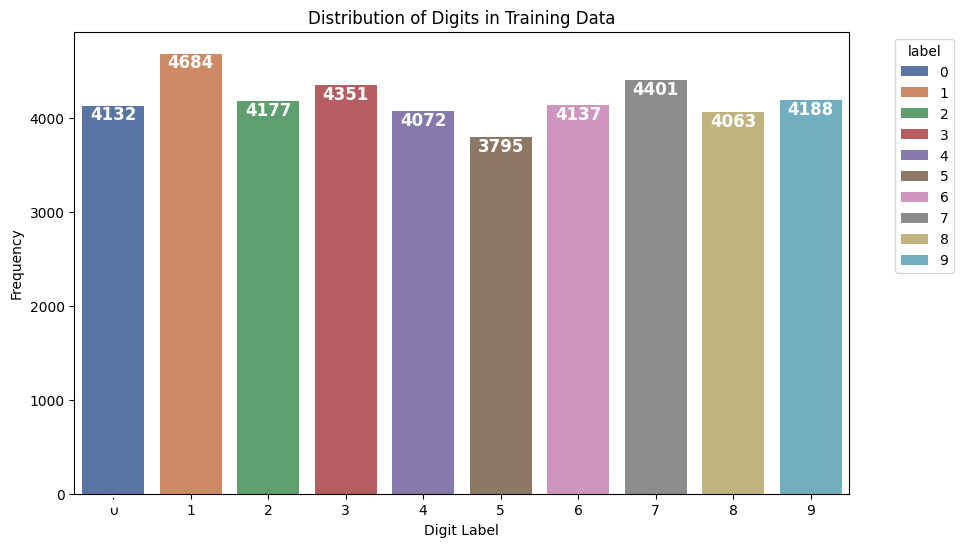

In [22]:
print(train_data['label'].value_counts())
# Plot distribution of labels
plt.figure(figsize=(10, 6))
ax = sns.countplot(train_data, x = 'label', palette='deep', hue = 'label')
# Annotate each bar with height of that bar mentioned inside the bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2, p.get_height() - 0.1),  # Adjust y-coordinate
                ha='center', va='top',  # Align text to the top within each bar
                fontsize=12, color='white', weight='bold')  # Text color for contrast

plt.legend(title='label', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Distribution of Digits in Training Data")
plt.xlabel("Digit Label")
plt.ylabel("Frequency")
plt.show()



### Sample Digit Images
We plot some sample images from the training dataset to see the handwritten digits.


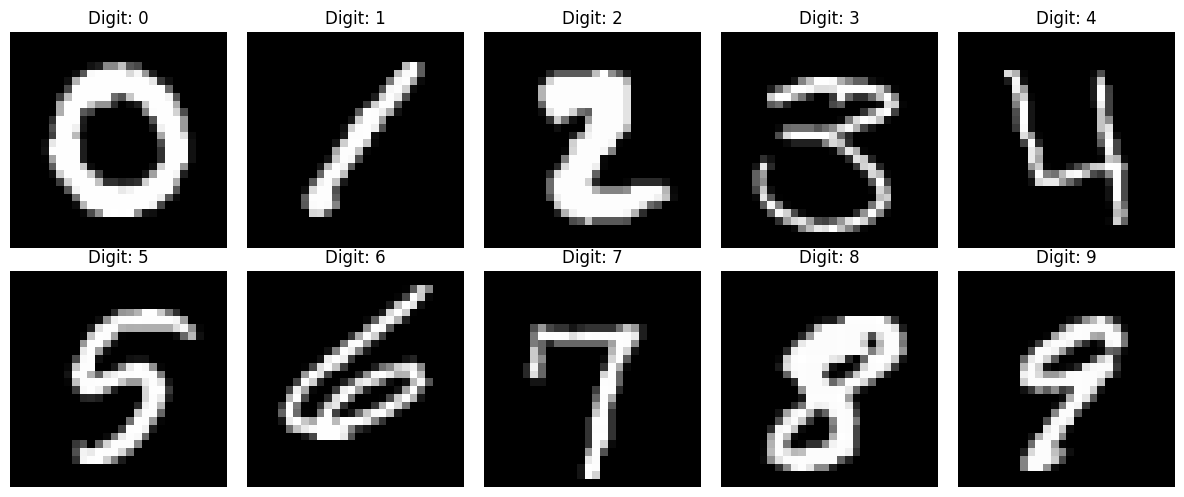

In [23]:
# Plot sample images
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.ravel()

for i in range(10):
    img = train_data[train_data['label'] == i].iloc[0, 1:].values.reshape(28, 28)
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f"Digit: {i}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()


### Multiple Sample Digit Images for each digit from range 0-9
We plot a few sample images from the training dataset to see the handwritten digits. This will be repeated for each digit from the range 0-9

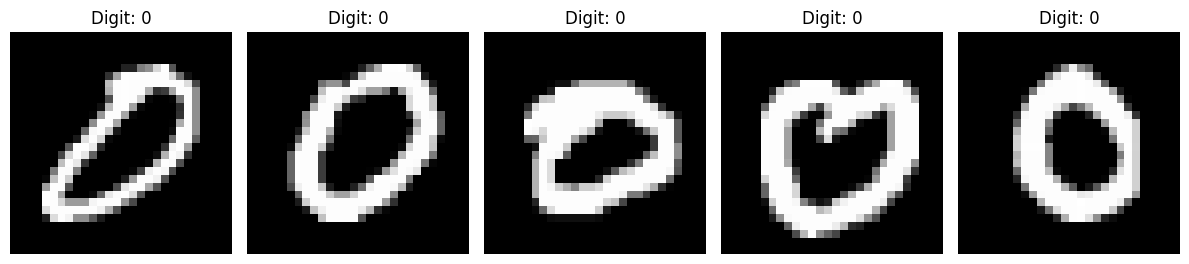

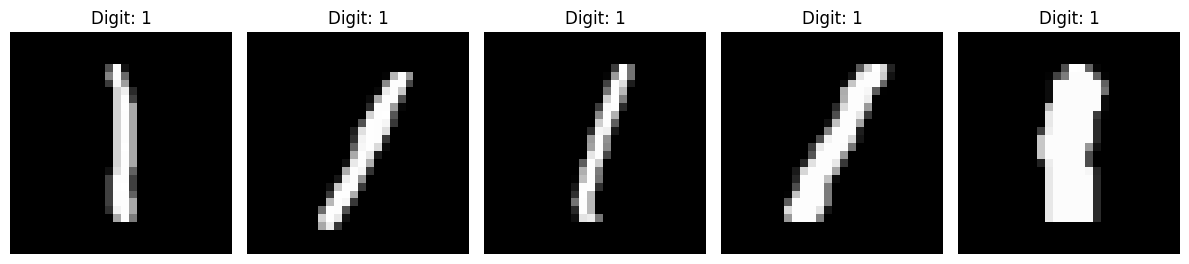

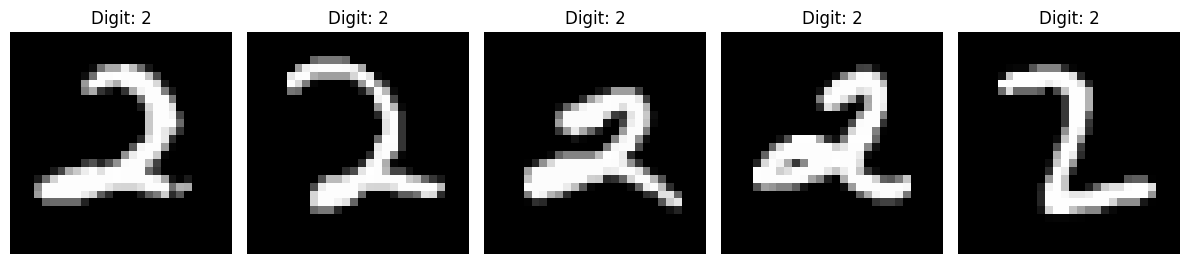

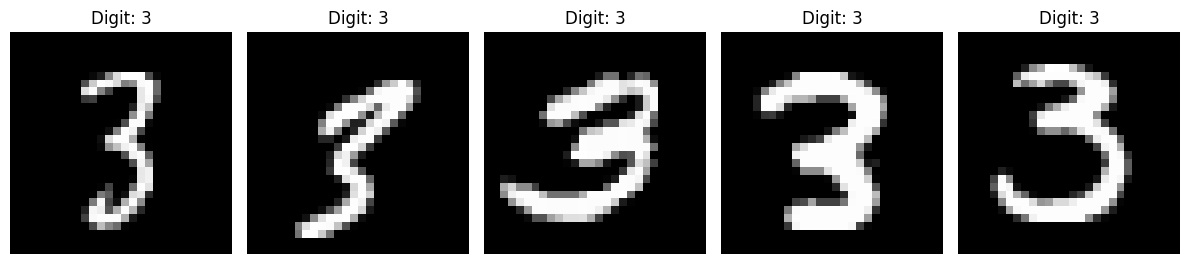

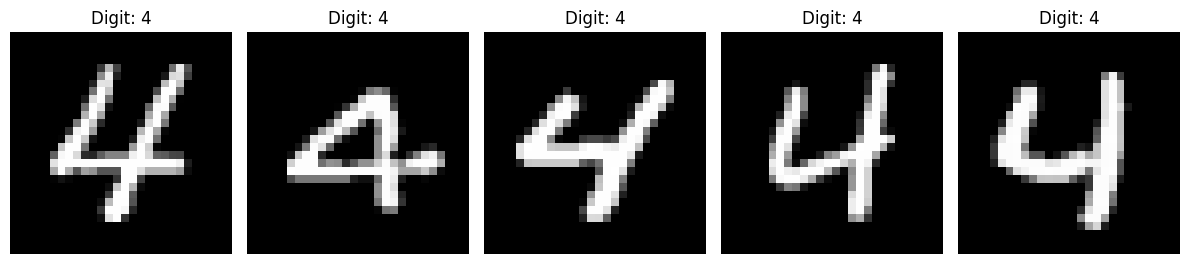

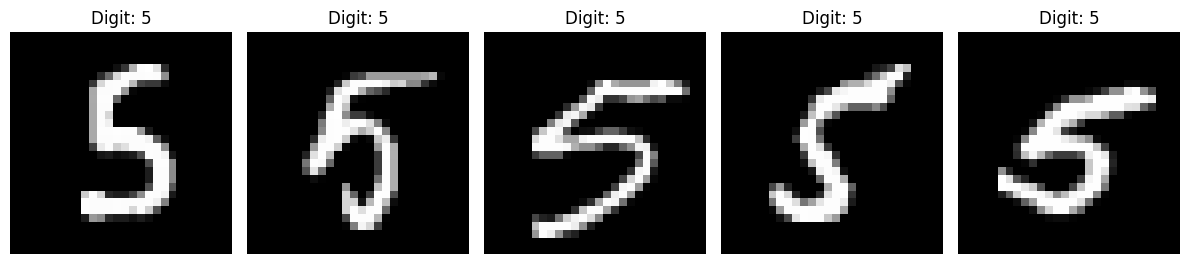

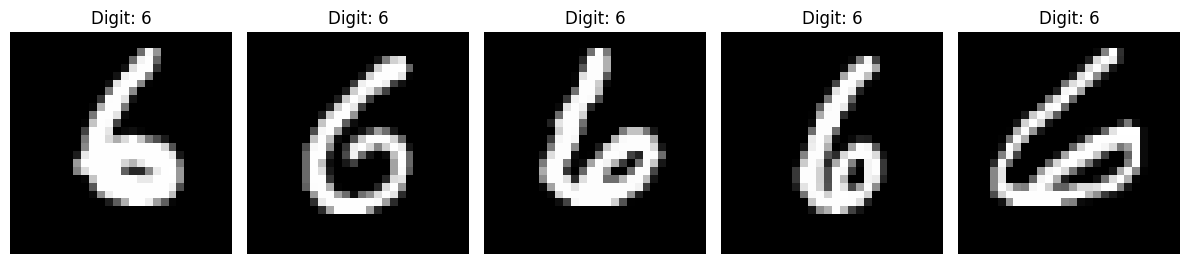

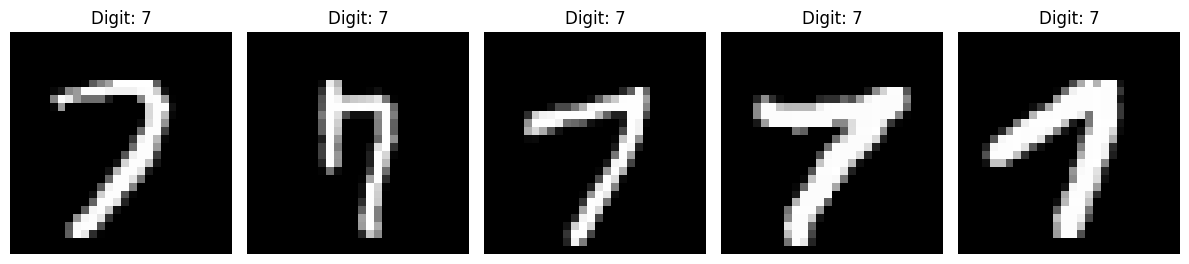

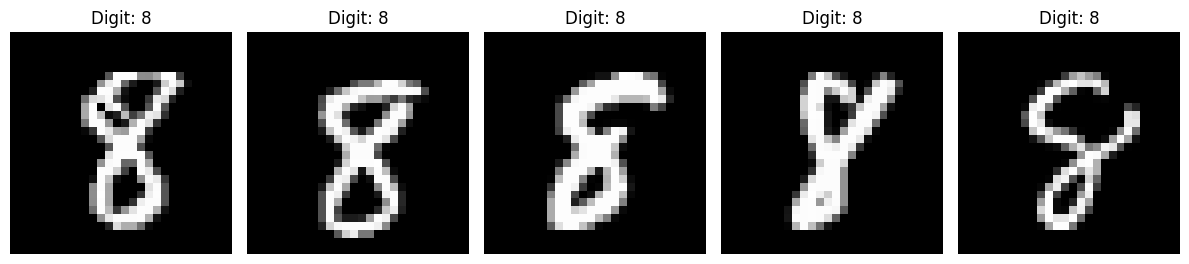

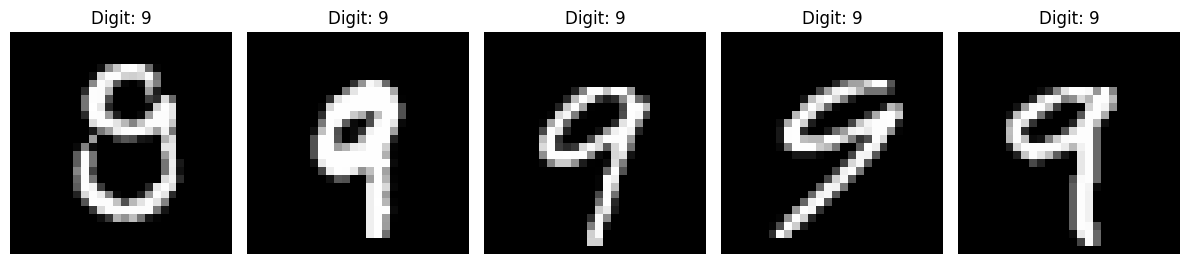

In [24]:
import random  # Import the random module for generating random numbers

def show_few_samples_of_num(num = 0):  # Define a function to display samples of a specific digit
  fig, axes = plt.subplots(1, 5, figsize=(12, 3))  # Create a figure and 5 subplots (1 row, 5 columns)
  axes = axes.ravel()  # Flatten the axes array for easy iteration
  samples_to_be_printed = 5  # Initialize the number of samples to print to 5
  num_of_samples = train_data['label'].value_counts()[num]  # Get the total number of samples for the given digit
  if num_of_samples < samples_to_be_printed:  # If there are fewer samples than desired
    samples_to_be_printed = num_of_samples  # Adjust the number of samples to print

  for i in range(samples_to_be_printed):  # Iterate through the desired number of samples
      img = train_data[train_data['label'] == num].iloc[random.randint(0, num_of_samples), 1:].values.reshape(28, 28)  # Select a random image of the digit, reshape it to 28x28
      axes[i].imshow(img, cmap='gray')  # Display the image on the subplot with a grayscale colormap
      axes[i].set_title(f"Digit: {num}")  # Set the title of the subplot to indicate the digit
      axes[i].axis('off')  # Hide axis ticks and labels

  plt.tight_layout()  # Adjust subplot spacing
  plt.show()  # Display the plot

for i in range(10):  # Iterate through digits 0 to 9
  show_few_samples_of_num(i)  # Call the function to display samples for each digit


## Data Preprocessing
To prepare the data for training, we normalize the pixel values and reshape the images.
Normalization helps improve model convergence.


In [25]:

# Separate features and labels
X_train = train_data.drop(columns=['label']).values
y_train = train_data['label'].values

# Normalize the data
X_train = X_train / 255.0
test_data = test_data / 255.0

# Reshape the data to include the channel dimension
X_train = X_train.reshape(-1, 28, 28, 1)
test_data = test_data.values.reshape(-1, 28, 28, 1)

# One-hot encode the labels
y_train = to_categorical(y_train, num_classes=10)

# Display shape of preprocessed data
X_train.shape, y_train.shape


((42000, 28, 28, 1), (42000, 10))


## Model Building
We build a Convolutional Neural Network (CNN) to classify the images. The model consists of convolutional and pooling layers,
followed by dense layers for classification.


In [26]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Build the CNN model
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

# Display the model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

## Display the model in graphical format for better depiction

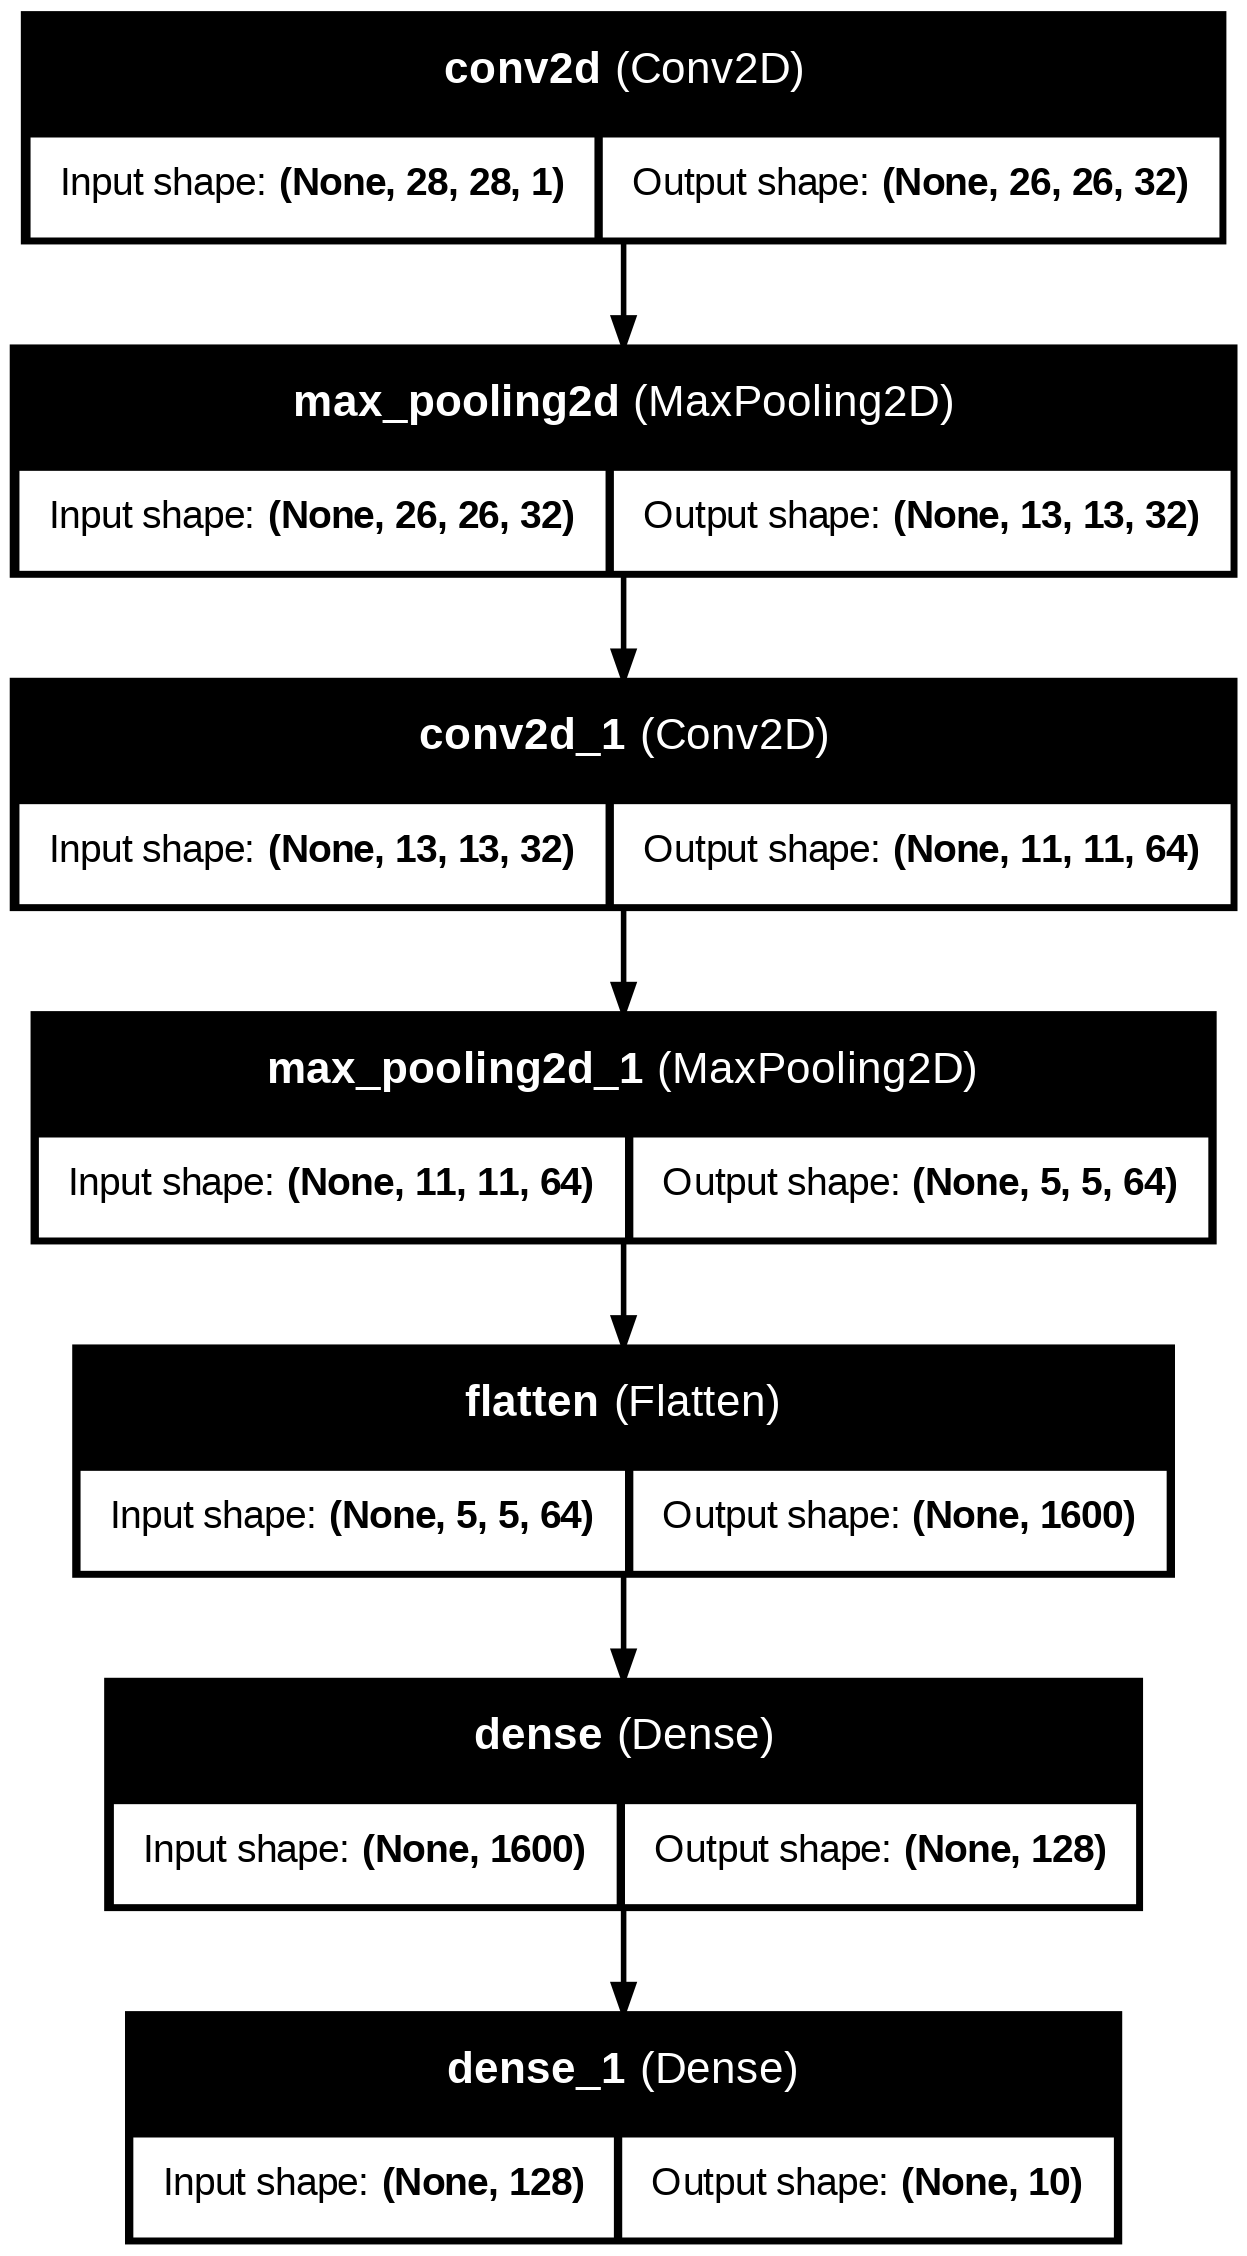

In [30]:
from tensorflow.keras.utils import plot_model
# Generate a plot of the model
plot_model(model, to_file='cnn_model.png', show_shapes=True, show_layer_names=True)

['/usr/share/fonts/truetype/liberation/LiberationMono-BoldItalic.ttf', '/usr/share/fonts/truetype/liberation/LiberationSerif-Regular.ttf', '/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf', '/usr/share/fonts/truetype/liberation/LiberationSerif-Italic.ttf', '/usr/share/fonts/truetype/liberation/LiberationSans-Bold.ttf', '/usr/share/fonts/truetype/liberation/LiberationSerif-BoldItalic.ttf', '/usr/share/fonts/truetype/liberation/LiberationSans-BoldItalic.ttf', '/usr/share/fonts/truetype/liberation/LiberationMono-Italic.ttf', '/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf', '/usr/share/fonts/truetype/humor-sans/Humor-Sans.ttf', '/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf', '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Bold.ttf', '/usr/share/fonts/truetype/liberation/LiberationSerif-Bold.ttf', '/usr/share/fonts/truetype/liberation/LiberationSans-Italic.ttf', '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-BoldItalic

/usr/local/lib/python3.10/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


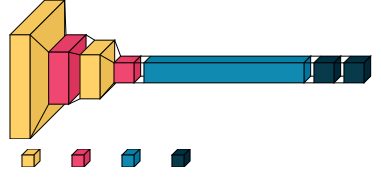

In [40]:
!pip install visualkeras
## doing it using visualkeras this time
import visualkeras
from PIL import ImageFont

# List available fonts
import matplotlib.font_manager
print(matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf'))

# Choose a font from the printed list
# and replace 'your_chosen_font.ttf' below
try:
    font = ImageFont.truetype("your_chosen_font.ttf", 32)
except OSError:
    print(f"Font not found. Please ensure 'your_chosen_font.ttf' is installed and accessible.")
    # If the font is still not found, you can try a generic font like 'FreeSans'
    # but it might not be visually appealing.
    font = ImageFont.load_default()

visualkeras.layered_view(model, legend=True, font=font)  # Pass the font to layered_view


## Model Training
We compile and train the model using the Adam optimizer and categorical cross-entropy loss function.
We'll train for 10 epochs and validate on a split of the training data.


In [27]:

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=200, validation_split=0.2)


Epoch 1/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 32s 183ms/step - accuracy: 0.7559 - loss: 0.8230 - val_accuracy: 0.9686 - val_loss: 0.1088
Epoch 2/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 31s 182ms/step - accuracy: 0.9701 - loss: 0.1007 - val_accuracy: 0.9792 - val_loss: 0.0686
Epoch 3/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 39s 171ms/step - accuracy: 0.9821 - loss: 0.0619 - val_accuracy: 0.9790 - val_loss: 0.0642
Epoch 4/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 42s 175ms/step - accuracy: 0.9839 - loss: 0.0519 - val_accuracy: 0.9824 - val_loss: 0.0553
Epoch 5/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 41s 174ms/step - accuracy: 0.9877 - loss: 0.0382 - val_accuracy: 0.9831 - val_loss: 0.0528
Epoch 6/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 41s 177ms/step - accuracy: 0.9906 - loss: 0.0330 - val_accuracy: 0.9852 - val_loss: 0.0440
Epoch 7/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 29s 171ms/step - accuracy: 0.9926 - loss: 0.0237 - val_accuracy: 0.9880 - val_loss: 0.0401
Epoch 8/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 43s 184ms/step - accuracy: 0.9940 - loss: 0


## Model Evaluation
Let's visualize the training and validation accuracy and loss curves to understand model performance over time.


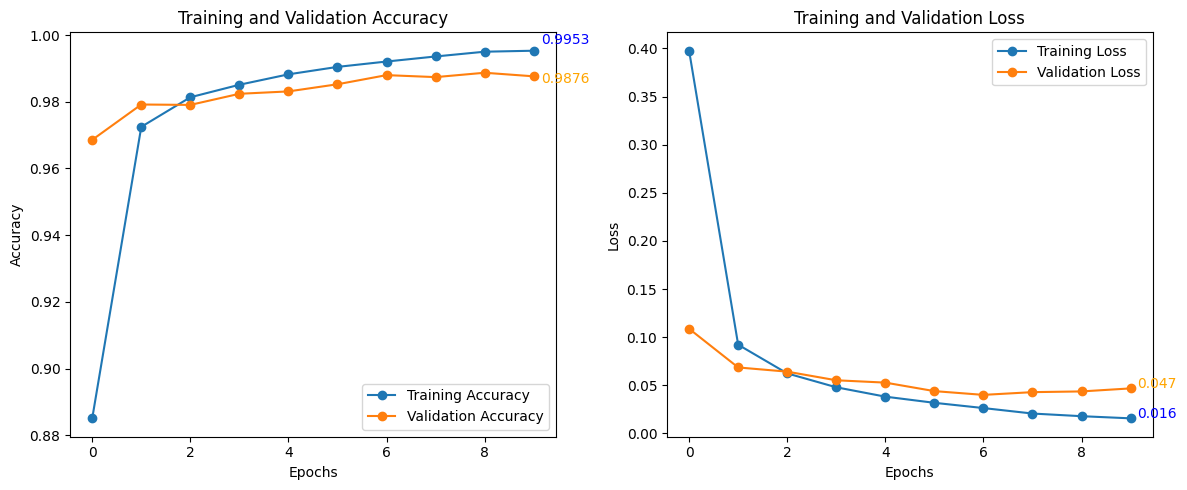

In [50]:
# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], marker='o', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], marker='o', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Annotate only the last point for accuracy and validation accuracy
last_epoch = len(history.history['accuracy']) - 1
plt.annotate(f'{history.history["accuracy"][-1]:.4f}',
             xy=(last_epoch, history.history['accuracy'][-1]),
             xytext=(5, 5), textcoords='offset points', color='blue')
plt.annotate(f'{history.history["val_accuracy"][-1]:.4f}',
             xy=(last_epoch, history.history['val_accuracy'][-1]),
             xytext=(5, -5), textcoords='offset points', color='orange')

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], marker='o', label='Training Loss')
plt.plot(history.history['val_loss'], marker='o', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Annotate only the last point for loss and validation loss
plt.annotate(f'{history.history["loss"][-1]:.3f}',
             xy=(last_epoch, history.history['loss'][-1]),
             xytext=(5, 0), textcoords='offset points', color='blue')
plt.annotate(f'{history.history["val_loss"][-1]:.3f}',
             xy=(last_epoch, history.history['val_loss'][-1]),
             xytext=(5, 0), textcoords='offset points', color='orange')

plt.tight_layout()
plt.show()

In [51]:
## Final value of lost and accuracy for both training and validation dateset after 10 epochs
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")

Final Training Accuracy: 0.9953
Final Validation Accuracy: 0.9876
Final Training Loss: 0.0157
Final Validation Loss: 0.0468



## Making Predictions and Submission
Finally, we make predictions on the test data and prepare a CSV file for submission to Kaggle.


In [29]:

# Predict on the test data
predictions = model.predict(test_data)
predicted_labels = np.argmax(predictions, axis=1)

# Prepare submission
submission = pd.DataFrame({'ImageId': np.arange(1, len(predicted_labels) + 1), 'Label': predicted_labels})
submission.to_csv('submission.csv', index=False)
submission.head()


875/875 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step


,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
